In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load contents, correlations and topics file
BASE_DIR = "data/"
content = pd.read_csv(BASE_DIR+"content.csv")
correlations = pd.read_csv(BASE_DIR+"correlations.csv")
topic = pd.read_csv(BASE_DIR+"topics.csv")

In [3]:
# Print the original size of the data
print("Original contents file shape:", content.shape)
print("Original topics file shape:", topic.shape)
print("Original correlations file shape:", correlations.shape)

Original contents file shape: (154047, 8)
Original topics file shape: (76972, 9)
Original correlations file shape: (61517, 2)


In [4]:
# Use only CONTENT whose language is english
english_filtered_content = content[content["language"]=="en"]
# Use only TOPICS whose language is english & has content & drop rows if there are any NAN present in the dataset
english_filtered_topics = topic[(topic["language"]=="en") & (topic["has_content"]==1)].dropna()

In [5]:
# Print the filtered size of the data
print("Filtered content shape:", english_filtered_content.shape)
print("Filtered topic shape:", english_filtered_topics.shape)
print("Filtered correlations shape:", correlations.shape)

Filtered content shape: (65939, 8)
Filtered topic shape: (9073, 9)
Filtered correlations shape: (61517, 2)


#### Filter based on content

In [6]:
# We want to focus on CONTENT which is available as a document or video or html5
english_filtered_content = english_filtered_content[(english_filtered_content["kind"]=="document")]
english_filtered_content = english_filtered_content.dropna()
print("Filtered content shape:", english_filtered_content.shape)

Filtered content shape: (6847, 8)


In [7]:
# First find the topics which are in correlations dataset and filtered english topic dataset
english_filtered_correlation = correlations[correlations['topic_id'].isin(english_filtered_topics['id'])]
# print(english_filtered_correlation.shape)
# Each topic has multiple contents inside it - so split the correlations dataset so that each topic is associated to a single content file
exploded_english_filtered_correlation = english_filtered_correlation.assign(content_ids=english_filtered_correlation['content_ids'].str.split()).explode('content_ids')
# print(english_filtered_correlation.shape)
# Find the contents which are in correlations dataset and filtered english content dataset
exploded_english_filtered_correlation = exploded_english_filtered_correlation[exploded_english_filtered_correlation['content_ids'].isin(english_filtered_content['id'])]
# print(english_filtered_correlation.shape)
# Count the number of content available for each topic
new_english_filtered_correlation = exploded_english_filtered_correlation["topic_id"].value_counts().to_frame('counts').reset_index()
# english_filtered_correlation_count

In [15]:
# Get topics that have the highest amount of content available
top_topics = new_english_filtered_correlation.iloc[0:3]
print(top_topics)
first_topic, second_topic, third_topic = top_topics.iloc[0,0], top_topics.iloc[1,0], top_topics.iloc[2,0]

            index  counts
0  t_58ca0afc0bae     270
1  t_17bf2af6d82b     214
2  t_ba5de272b4cb     205


In [16]:
first_topic_content = english_filtered_correlation[english_filtered_correlation['topic_id']==first_topic]["content_ids"]
second_topic_content = english_filtered_correlation[english_filtered_correlation['topic_id']==second_topic]["content_ids"]
third_topic_content = english_filtered_correlation[english_filtered_correlation['topic_id']==third_topic]["content_ids"]

In [17]:
first_list = first_topic_content.str.split().tolist()
second_list = second_topic_content.str.split().tolist()
third_list = third_topic_content.str.split().tolist()
final_list = first_list[0] + second_list[0] + third_list[0]
len(final_list)

689

In [37]:
len(first_list[0])
clustering = 

270

In [18]:
curriculum_dataframe = pd.DataFrame({"content_ids":final_list})
curriculum_dataframe

,content_ids
0,c_0286ded417a2
1,c_02a5e75e01f0
2,c_02adc62b7731
3,c_04213823e40c
4,c_044e55056282
...,...
684,c_faaee2aa0f68
685,c_fafd5fbf6f0b
686,c_fb3c7cd4c54c
687,c_fe6fc756cb19


In [19]:
new_curriculum_dataframe = pd.merge(curriculum_dataframe,english_filtered_content,left_on="content_ids", right_on="id").drop(["id", "language", "kind", "license", "copyright_holder"],axis=1)
new_curriculum_dataframe

,content_ids,title,description,text
0,c_0286ded417a2,Chapter 142: RenderScript,Chapter 142 of the book on Android.,Chapter 142: RenderScript\nRenderScript is a s...
1,c_02a5e75e01f0,Chapter 161: TransitionDrawable,Chapter 161 of the book on Android.,Chapter 161: TransitionDrawable\nSection 161.1...
2,c_02adc62b7731,Chapter 31: Supporting Screens With Dierent R...,Chapter 31 of the book on Android.,Chapter 31: Supporting Screens With\nDierent ...
3,c_04213823e40c,Chapter 93: RoboGuice,Chapter 93 of the book on Android.,Chapter 93: RoboGuice\nSection 93.1: Simple ex...
4,c_044e55056282,Chapter 219: Gson,Chapter 219 of the book on Android.,Chapter 219: Gson\nGson is a Java library that...
...,...,...,...,...
684,c_faaee2aa0f68,Chapter 97: Property Objects,Chapter 97 of the book on Python.,Chapter 97: Property Objects\nSection 97.1: Us...
685,c_fafd5fbf6f0b,Chapter 45: Math Module,Chapter 45 of the book on Python.,Chapter 45: Math Module\nSection 45.1: Roundin...
686,c_fb3c7cd4c54c,Chapter 109: The Interpreter (Command Line Con...,Chapter 109 of the book on Python.,Chapter 109: The Interpreter (Command\nLine Co...
687,c_fe6fc756cb19,Chapter 2: Python Data Types,Chapter 2 of the book on Python.,Chapter 2: Python Data Types\nData types are n...


In [20]:
def remove_stopwords(text):
    '''
    Checks language of text then removes stopwords from that language if supported.
    '''
    lang_code = text[0:2]
    for word in stopwords.words("english"):
        text = text.replace(' ' + word + ' ', ' ')
    return text

In [21]:
#### Apply remove_stopwords() to our data
new_curriculum_dataframe["new_title"] = new_curriculum_dataframe.title.apply(remove_stopwords)
new_curriculum_dataframe["new_text"] = new_curriculum_dataframe.text.apply(remove_stopwords)
new_curriculum_dataframe["new_description"] = new_curriculum_dataframe.description.apply(remove_stopwords)

In [22]:
new_curriculum_dataframe.head()

,content_ids,title,description,text,new_title,new_text,new_description
0,c_0286ded417a2,Chapter 142: RenderScript,Chapter 142 of the book on Android.,Chapter 142: RenderScript\nRenderScript is a s...,Chapter 142: RenderScript,Chapter 142: RenderScript\nRenderScript script...,Chapter 142 book Android.
1,c_02a5e75e01f0,Chapter 161: TransitionDrawable,Chapter 161 of the book on Android.,Chapter 161: TransitionDrawable\nSection 161.1...,Chapter 161: TransitionDrawable,Chapter 161: TransitionDrawable\nSection 161.1...,Chapter 161 book Android.
2,c_02adc62b7731,Chapter 31: Supporting Screens With Dierent R...,Chapter 31 of the book on Android.,Chapter 31: Supporting Screens With\nDierent ...,Chapter 31: Supporting Screens With Dierent R...,Chapter 31: Supporting Screens With\nDierent ...,Chapter 31 book Android.
3,c_04213823e40c,Chapter 93: RoboGuice,Chapter 93 of the book on Android.,Chapter 93: RoboGuice\nSection 93.1: Simple ex...,Chapter 93: RoboGuice,Chapter 93: RoboGuice\nSection 93.1: Simple ex...,Chapter 93 book Android.
4,c_044e55056282,Chapter 219: Gson,Chapter 219 of the book on Android.,Chapter 219: Gson\nGson is a Java library that...,Chapter 219: Gson,Chapter 219: Gson\nGson Java library used conv...,Chapter 219 book Android.


In [23]:
def preprocess_text(text: str) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove
    text = re.sub(":"," ", text)
    #
    text = re.sub("\n"," ", text)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [24]:
new_curriculum_dataframe['text'] = new_curriculum_dataframe['new_text'].apply(lambda x: preprocess_text(x))
new_curriculum_dataframe['title'] = new_curriculum_dataframe['new_title'].apply(lambda x: preprocess_text(x))
new_curriculum_dataframe['description'] = new_curriculum_dataframe['new_description'].apply(lambda x: preprocess_text(x))

In [25]:
new_curriculum_dataframe.head()

,content_ids,title,description,text,new_title,new_text,new_description
0,c_0286ded417a2,chapter renderscript,chapter book android,chapter renderscript renderscript scripting la...,Chapter 142: RenderScript,Chapter 142: RenderScript\nRenderScript script...,Chapter 142 book Android.
1,c_02a5e75e01f0,chapter transitiondrawable,chapter book android,chapter transitiondrawable section animate vie...,Chapter 161: TransitionDrawable,Chapter 161: TransitionDrawable\nSection 161.1...,Chapter 161 book Android.
2,c_02adc62b7731,chapter supporting screens with di erent resol...,chapter book android,chapter supporting screens with di erent resol...,Chapter 31: Supporting Screens With Dierent R...,Chapter 31: Supporting Screens With\nDierent ...,Chapter 31 book Android.
3,c_04213823e40c,chapter roboguice,chapter book android,chapter roboguice section simple example robog...,Chapter 93: RoboGuice,Chapter 93: RoboGuice\nSection 93.1: Simple ex...,Chapter 93 book Android.
4,c_044e55056282,chapter gson,chapter book android,chapter gson gson java library used convert ja...,Chapter 219: Gson,Chapter 219: Gson\nGson Java library used conv...,Chapter 219 book Android.


In [26]:
new_curriculum_dataframe["corpus"] = new_curriculum_dataframe["title"] + " " + new_curriculum_dataframe["description"] + " " + new_curriculum_dataframe["text"] 
new_curriculum_dataframe["corpus"] = new_curriculum_dataframe["corpus"].str.replace("chapter","")

In [27]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(new_curriculum_dataframe["text"])

In [28]:
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=3, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [29]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=3, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
x2 = pca_vecs[:, 2]

In [30]:
pca_vecs

array([[ 0.04308186, -0.13738634,  0.13375004],
       [ 0.36531057,  0.05354627,  0.17386966],
       [ 0.14956281, -0.00736221,  0.1108181 ],
       ...,
       [-0.22246239, -0.25152045,  0.04809886],
       [-0.15776488, -0.13088821,  0.11058601],
       [-0.15928802, -0.20077028,  0.18033594]])

In [31]:
# assign clusters and pca vectors to our dataframe 
new_curriculum_dataframe['cluster'] = clusters
new_curriculum_dataframe['x0'] = x0
new_curriculum_dataframe['x1'] = x1
new_curriculum_dataframe['x2'] = x2

In [32]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
use,data,list,module,the,function,import,def,print,python

Cluster 1
activity,private,layout,string,override,int,void,new,public,android

Cluster 2
nsstring,view,nil,func,objective,swift,self,let,developer,ios


In [33]:
# map clusters to appropriate labels 
cluster_map = {0: "Topic 1", 1: "Topic 2", 2: "Topic 3"}
# apply mapping
new_curriculum_dataframe['cluster'] = new_curriculum_dataframe['cluster'].map(cluster_map)

In [34]:
new_curriculum_dataframe

,content_ids,title,description,text,new_title,new_text,new_description,corpus,cluster,x0,x1,x2
0,c_0286ded417a2,chapter renderscript,chapter book android,chapter renderscript renderscript scripting la...,Chapter 142: RenderScript,Chapter 142: RenderScript\nRenderScript script...,Chapter 142 book Android.,renderscript book android renderscript rend...,Topic 2,0.043082,-0.137386,0.133750
1,c_02a5e75e01f0,chapter transitiondrawable,chapter book android,chapter transitiondrawable section animate vie...,Chapter 161: TransitionDrawable,Chapter 161: TransitionDrawable\nSection 161.1...,Chapter 161 book Android.,transitiondrawable book android transitiond...,Topic 2,0.365311,0.053546,0.173870
2,c_02adc62b7731,chapter supporting screens with di erent resol...,chapter book android,chapter supporting screens with di erent resol...,Chapter 31: Supporting Screens With Dierent R...,Chapter 31: Supporting Screens With\nDierent ...,Chapter 31 book Android.,supporting screens with di erent resolutions ...,Topic 2,0.149563,-0.007362,0.110818
3,c_04213823e40c,chapter roboguice,chapter book android,chapter roboguice section simple example robog...,Chapter 93: RoboGuice,Chapter 93: RoboGuice\nSection 93.1: Simple ex...,Chapter 93 book Android.,roboguice book android roboguice section si...,Topic 2,0.249197,-0.049074,0.041420
4,c_044e55056282,chapter gson,chapter book android,chapter gson gson java library used convert ja...,Chapter 219: Gson,Chapter 219: Gson\nGson Java library used conv...,Chapter 219 book Android.,gson book android gson gson java library us...,Topic 2,0.067048,-0.129299,-0.014321
...,...,...,...,...,...,...,...,...,...,...,...,...
684,c_faaee2aa0f68,chapter property objects,chapter book python,chapter property objects section using propert...,Chapter 97: Property Objects,Chapter 97: Property Objects\nSection 97.1: Us...,Chapter 97 book Python.,property objects book python property objec...,Topic 1,-0.172595,-0.065255,0.102675
685,c_fafd5fbf6f0b,chapter math module,chapter book python,chapter math module section rounding round oor...,Chapter 45: Math Module,Chapter 45: Math Module\nSection 45.1: Roundin...,Chapter 45 book Python.,math module book python math module section...,Topic 1,-0.150507,-0.160504,0.118040
686,c_fb3c7cd4c54c,chapter the interpreter command line console,chapter book python,chapter the interpreter command line console s...,Chapter 109: The Interpreter (Command Line Con...,Chapter 109: The Interpreter (Command\nLine Co...,Chapter 109 book Python.,the interpreter command line console book py...,Topic 1,-0.222462,-0.251520,0.048099
687,c_fe6fc756cb19,chapter python data types,chapter book python,chapter python data types data types nothing v...,Chapter 2: Python Data Types,Chapter 2: Python Data Types\nData types nothi...,Chapter 2 book Python.,python data types book python python data t...,Topic 1,-0.157765,-0.130888,0.110586


### Plotting

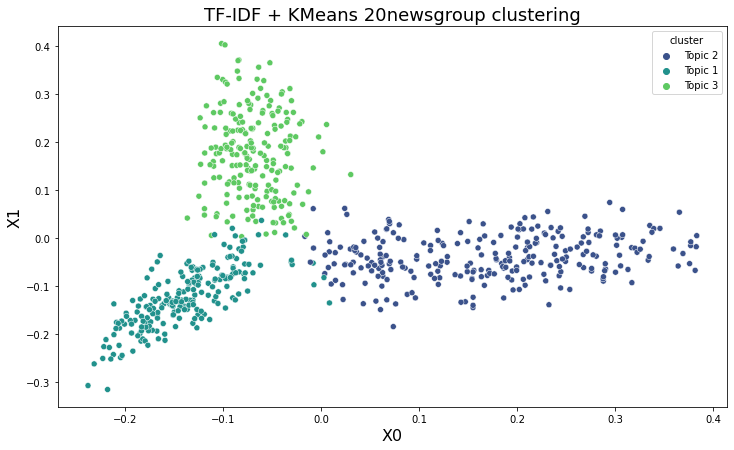

In [35]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=new_curriculum_dataframe, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()